In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, silhouette_score
import skfuzzy as fuzz
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# sklearn.set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
flight_data_train = pd.read_csv('./flight_data_train_ts.csv')
flight_data_test = pd.read_csv('./flight_data_test_ts.csv')

In [3]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

# flight_data_train.sort_values(by='scheduledoffblocktime', inplace=True)
# flight_data_test.sort_values(by='scheduledoffblocktime', inplace=True)

Feature Selection

In [4]:
def chi_2(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic for {x} and {y}: {chi2}, p-value: {p}, dof:{dof}")

In [5]:
def cramers_v(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cor = np.sqrt(chi2 / (n * min_dim))
    print(f"Cramer's V  for {x} and {y}: {cor}, p-value: {p}")

In [6]:
flight_data_train.columns

Index(['scheduledoffblocktime', 'traffictypecode', 'airlinecode_iata',
       'destination_iata', 'aircraft_iata', 'isconnecting', 'publicgatenumber',
       'aircraftterminal', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti',
       'vsby', 'gust', 'skyc1', 'skyc2', 'skyl1', 'skyl2', 'finalflightstatus',
       'delay_in_secs'],
      dtype='object')

In [7]:
chi_2(flight_data_train, 'publicgatenumber', 'finalflightstatus')
cramers_v(flight_data_train, 'publicgatenumber', 'finalflightstatus')

Chi-Square Statistic for publicgatenumber and finalflightstatus: 3653.5185592382445, p-value: 0.0, dof:138
Cramer's V  for publicgatenumber and finalflightstatus: 0.14586302601258685, p-value: 0.0


In [8]:
chi_2(flight_data_train, 'destination_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'destination_iata', 'finalflightstatus')

Chi-Square Statistic for destination_iata and finalflightstatus: 8301.845466494837, p-value: 0.0, dof:311
Cramer's V  for destination_iata and finalflightstatus: 0.21987552153760798, p-value: 0.0


In [9]:
chi_2(flight_data_train, 'aircraft_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'aircraft_iata', 'finalflightstatus')

Chi-Square Statistic for aircraft_iata and finalflightstatus: 3711.169825246382, p-value: 0.0, dof:60
Cramer's V  for aircraft_iata and finalflightstatus: 0.14700935572653068, p-value: 0.0


In [10]:
chi_2(flight_data_train, 'airlinecode_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'airlinecode_iata', 'finalflightstatus')

Chi-Square Statistic for airlinecode_iata and finalflightstatus: 9039.246389847638, p-value: 0.0, dof:149
Cramer's V  for airlinecode_iata and finalflightstatus: 0.22943288824568359, p-value: 0.0


In [11]:
# columns_to_drop = ['publicgatenumber']

# flight_data_train.drop(columns=columns_to_drop, axis=1, inplace=True)
# flight_data_test.drop(columns=columns_to_drop, axis=1, inplace=True)

In [12]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [13]:
X_train = flight_data_train.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)
X_test = flight_data_test.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)

y_train = flight_data_train['finalflightstatus']
y_test = flight_data_test['finalflightstatus']

In [14]:
y_train = y_train.map({'On-Time': 0, 'Delayed':1})
y_test = y_test.map({'On-Time': 0, 'Delayed':1})

In [15]:
X_train

,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute
0,PS,RA,KTM,332,0,F8,2,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,265
1,PS,ET,ADD,77W,0,D6,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,265
2,PS,6E,BOM,320,0,D7,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,270
3,PS,EK,MLE,77W,0,C14,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,0.0,8,3,6,275
4,PS,EK,CGK,77W,0,A8,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,0.0,8,3,6,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171715,PS,EK,BRU,77W,0,B29,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171716,PS,EK,IST,77W,0,B10,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171717,PS,EK,DUS,388,0,B17,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171718,PS,EK,LIS,77W,0,B22,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,865


In [16]:
# from imblearn.over_sampling import SMOTENC

# smote = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3, 5, 16, 17])
# print('Original dataset shape %s' % Counter(y_train_cls))
# X_train, y_train_cls = smote.fit_resample(X_train, y_train_cls)
# print('Resampled dataset shape %s' % Counter(y_train_cls))


In [17]:
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

X_train_encoded = catboost_encoder.fit_transform(X_train, y_train)

X_test_encoded = catboost_encoder.transform(X_test)

X_train = X_train_encoded
X_test = X_test_encoded

In [18]:
# one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', 'airlinecode_iata', 'destination_iata']
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', ]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded = ohe.fit_transform(X_train[one_hot_column])
ohe_new_columns = ohe.get_feature_names_out(one_hot_column)
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



In [19]:
numerical_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'skyl1', 'skyl2']

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [21]:
# Create cyclic features for month and day
X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# Drop original features
X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


In [22]:
X_train

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyl1,skyl2,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,depart_month_sin,depart_month_cos,depart_day_sin,depart_day_cos,depart_dayofweek_sin,depart_dayofweek_cos,depart_minute_sin,depart_minute_cos
0,0.274493,0.274493,0.274493,0,0.274493,0.242424,0.650,0.767540,0.250000,0.185185,0.652632,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.915311,0.402747
1,0.274493,0.274493,0.274493,0,0.274493,0.242424,0.650,0.767540,0.250000,0.185185,0.652632,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.915311,0.402747
2,0.274493,0.274493,0.274493,0,0.274493,0.242424,0.650,0.767540,0.250000,0.185185,0.652632,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.923880,0.382683
3,0.274493,0.274493,0.137247,0,0.274493,0.212121,0.625,0.765962,0.305556,0.222222,0.652632,0.899676,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.932008,0.362438
4,0.137247,0.274493,0.091498,0,0.274493,0.212121,0.625,0.765962,0.305556,0.222222,0.652632,0.899676,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.932008,0.362438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171715,0.224980,0.155440,0.208386,0,0.225553,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.573576,-0.819152
171716,0.224991,0.239724,0.208400,0,0.175686,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.573576,-0.819152
171717,0.224988,0.194093,0.343861,0,0.262227,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.573576,-0.819152
171718,0.224985,0.285690,0.208397,0,0.187338,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.591310,-0.806445


In [23]:
# from sklearn.cluster import KMeans
# inertia = []
# for k in range(2,100):
#     model = KMeans(n_clusters=k, random_state=42).fit(X_train)
#     inertia.append(model.inertia_)
 
# k_values = range(2,100)
# plt.plot(k_values, inertia, 'o-')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')

In [24]:
# def determine_optimal_clusters(X_train, max_clusters=10):
#     fpcs = []
#     for n_clusters in range(2, max_clusters + 1):
#         cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
#             X_train.T, c=n_clusters, m=1.1, error=1e-5, maxiter=150, init=None, seed=42
#         )
#         fpcs.append(fpc)

#     # Plot FPC values to determine the optimal number of clusters
#     plt.plot(range(2, max_clusters + 1), fpcs, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Fuzzy Partition Coefficient (FPC)')
#     plt.title('FPC vs. Number of Clusters')
#     plt.show()
# determine_optimal_clusters(X_train, max_clusters=10)

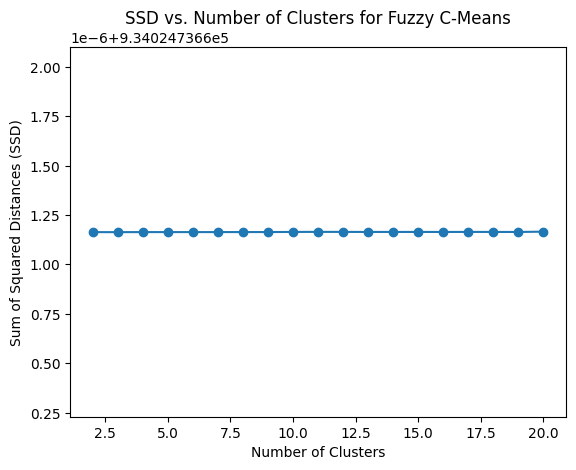

In [27]:
ssds = []
max_clusters = 20

for n in range(2, max_clusters + 1):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_train.T, c=n, m=1.5, error=1e-5, maxiter=150, init=None, seed=42)
    probabilities_train = u.T
    ssd = 0
    for i in range(n):
        distances = np.linalg.norm(X_train.values - cntr[i], axis=1) ** 2
        weighted_distances = probabilities_train[:, i] * distances
        ssd += np.sum(weighted_distances)
    ssds.append(ssd)

# Plot the SSD values
plt.figure()
plt.plot(range(2, max_clusters + 1), ssds, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('SSD vs. Number of Clusters for Fuzzy C-Means')
plt.show()

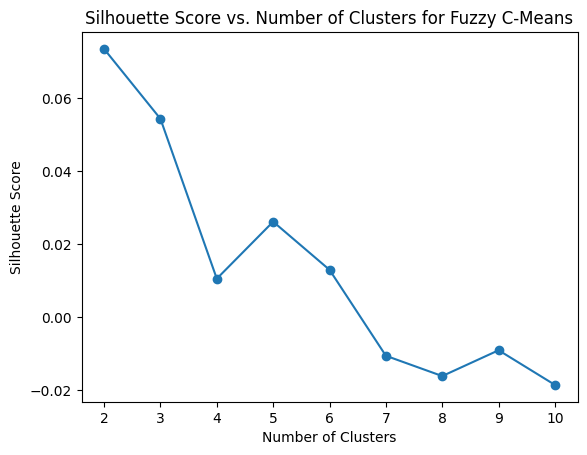

Optimal number of clusters based on Silhouette Score: 2


: 

In [30]:
silhouette_scores = []
max_clusters = 10

for n_clusters in range(2, max_clusters + 1):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_train.T, n_clusters, m=1.5, error=1e-5, maxiter=150, init=None, seed=42)
    clusters_train = np.argmax(u, axis=0)
    silhouette_avg = silhouette_score(X_train, clusters_train)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure()
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for Fuzzy C-Means')
plt.show()

# Select the optimal number of clusters based on the highest silhouette score
optimal_n_clusters = 2 + np.argmax(silhouette_scores)
print(f"Optimal number of clusters based on Silhouette Score: {optimal_n_clusters}")


In [25]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())


# Define objective function for hyperopt
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2']),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
}
# Use Bayesian optimization for hyperparameter tuning
bayes_cv = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=param_space,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)
bayes_cv.fit(X_train_balanced, y_train_balanced)
best_rf = bayes_cv.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Performance without clustering:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("==========================================")
print()


Original class distribution:
finalflightstatus
0    124584
1     47136
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    124584
1    124584
Name: count, dtype: int64


/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Performance without clustering:
Accuracy: 0.6201981028247996
Precision: 0.31447347331303094
Recall: 0.3978102189781022
F1 Score: 0.35126667263450007



In [72]:
n_clusters = 5
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_train.T, n_clusters, m=1.5, error=1e-5, maxiter=150, init=None, seed=42)
clusters_train = np.argmax(u, axis=0)
probabilities_train = u.T

In [81]:
X_train['cluster'] = pd.DataFrame(np.argmax(probabilities_train, axis=1))
X_train['cluster'].value_counts()

cluster
4    66731
1    44934
0    35146
3    22449
2     2460
Name: count, dtype: int64

In [82]:
u_test, _, _, _, _, _ = fuzz.cluster.cmeans_predict(X_test.T, cntr, m=1.5, error=1e-5, maxiter=150)
probabilities_test = u_test.T
pd.DataFrame(np.argmax(probabilities_test, axis=1)).value_counts()

0
4    9188
0    4274
1    2578
3    2383
2     658
Name: count, dtype: int64

In [86]:
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

rf_models = {}
metrics = {}

for cluster in np.sort(X_train['cluster'].unique()):    
    print(f'Cluster {cluster}')

    # Subset the training and test data for the cluster
    # Get cluster data
    X_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_cluster = y_train.loc[X_cluster.index]
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_cluster, y_cluster)

# Print class distribution before and after SMOTE
    print("Original class distribution:")
    print(pd.Series(y_cluster).value_counts())
    print("\nBalanced class distribution:")
    print(pd.Series(y_train_balanced).value_counts())

    # Define objective function for hyperopt
    param_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    }

    # Use Bayesian optimization for hyperparameter tuning
    bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=param_space,
        n_iter=5,
        cv=3,
        n_jobs=-1,
        scoring='f1',
        random_state=42
    )
    bayes_cv.fit(X_train_balanced, y_train_balanced)
    best_rf = bayes_cv.best_estimator_
    rf_models[cluster] = best_rf
    print(f'Cluster {cluster} completed. Score: {bayes_cv.best_score_}')
    print('==========================================')
    print()


Cluster 3
Original class distribution:
finalflightstatus
0    16990
1     5459
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    16990
1    16990
Name: count, dtype: int64
Cluster 3 completed. Score: 0.5929349586010889

Cluster 2
Original class distribution:
finalflightstatus
0    1714
1     746
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    1714
1    1714
Name: count, dtype: int64
Cluster 2 completed. Score: 0.5769175961983604

Cluster 4
Original class distribution:
finalflightstatus
0    49321
1    17410
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    49321
1    49321
Name: count, dtype: int64
Cluster 4 completed. Score: 0.5740001172361809

Cluster 0
Original class distribution:
finalflightstatus
0    25419
1     9727
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    25419
1    25419
Name: count, dtype: int64
Cluster 0 completed. Score: 0.5671964198961552

Cluster 

/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 1 completed. Score: 0.5509082474601338



In [95]:
final_predictions = []
all_y_true = []
for idx in X_test.index:
    probabilities = probabilities_test[idx]
    
    weighted_votes = {}
    for model_cluster, model in rf_models.items():
        weight = probabilities[model_cluster]  # Use FCM membership probabilities as weights
        prediction = model.predict(X_test.loc[[idx]])[0]
        if prediction in weighted_votes:
            weighted_votes[prediction] += weight
        else:
            weighted_votes[prediction] = weight
    # Final prediction is the weighted average
    final_prediction = max(weighted_votes, key=weighted_votes.get)
    final_predictions.append(final_prediction)
    all_y_true.append(y_test.loc[idx])


In [97]:
# Calculate overall metrics
overall_accuracy = accuracy_score(all_y_true, final_predictions)
overall_precision = precision_score(all_y_true, final_predictions)
overall_recall = recall_score(all_y_true, final_predictions)
overall_f1 = f1_score(all_y_true, final_predictions)

print("\nOverall Metrics (Weighted FCM Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Overall Metrics (Weighted FCM Ensemble):
Overall Accuracy: 0.6783711545516482
Overall Precision: 0.34578960839518813
Overall Recall: 0.27392538523925386
Overall F1 Score: 0.30569068899196744
